# Lab 1 Task 1

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [14]:
!pip install matplotlib numpy tqdm 

  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached numpy-2.3.3

In [15]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
%cd /content/drive/MyDrive/AI_lab/Lab1\ Material

[Errno 2] No such file or directory: '/content/drive/MyDrive/AI_lab/Lab1 Material'
/home/n26141826/Lab1 Material


In [1]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

In [2]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [3]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # y = x @ W + b
        # x: (N, in_features), W: (in_features, out_features), b: (1, out_features)
        self.x = x
        return x @ self.W.data + self.b.data

    def backward(self, dy):
        # dy: (N, out_features)
        # dW = x^T @ dy, db = sum(dy), dx = dy @ W^T
        dW = self.x.T @ dy                                  # (in_features, out_features)
        db = np.sum(dy, axis=0, keepdims=True)              # (1, out_features)
        dx = dy @ self.W.data.T                             # (N, in_features)

        # 寫回參數的梯度（通常外面會有 zero_grad() 再累加或覆蓋）
        self.W.grad = dW
        self.b.grad = db
        return dx

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # y = max(0, x)
        self.x = x
        return np.maximum(0, x)

    def backward(self, dy):
        # dy ⊙ 1_{x > 0}
        mask = (self.x > 0).astype(dy.dtype)
        return dy * mask

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # y = 1 / (1 + exp(-x))
        # 儲存 y 以便 backward 使用 y*(1-y)
        y = 1.0 / (1.0 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dy):
        # dy ⊙ y(1 - y)
        return dy * (self.y * (1.0 - self.y))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 數值穩定 softmax
        # x: (N, C)
        x_shift = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(x_shift)
        y = exps / np.sum(exps, axis=1, keepdims=True)
        self.y = y
        return y

    def backward(self, dy):
        # 通常與 Cross-Entropy 合併成簡化梯度 (y - one_hot)
        # 這裡維持講義設定：在 CE Loss 內完成簡化，因此此處直接回傳 dy
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


In [4]:

class MLP(Module):
    def __init__(self) -> None:
        # 保持原模板的 __init__ 介面（不帶參數）
        self.fc1 = Linear(28*28, 256)
        self.act1 = ReLU()
        self.fc2 = Linear(256, 10)

    def forward(self, x):
        # x: (N, 784) with values in [0,1]
        z1 = self.fc1(x)
        a1 = self.act1(z1)
        z2 = self.fc2(a1)  # logits
        return z2

    def backward(self, dy):
        # dy: gradient w.r.t logits
        dz2 = self.fc2.backward(dy)
        dz1 = self.act1.backward(dz2)
        dx  = self.fc1.backward(dz1)
        return dx

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()


## 2. Implement training and testing process
* included cross-validation

In [5]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='../data', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [6]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root=".", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        # 學生實作部分：split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        n = len(dataset)
        indices = np.random.permutation(n)
        n_valid = int(n * split_ratio)
        valid_indices = indices[:n_valid]
        train_indices = indices[n_valid:]
        return Subset(dataset, train_indices), Subset(dataset, valid_indices)



    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [7]:

class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)


In [8]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0.0
    for x, y in tqdm(trainldr):
        # 1) forward
        logits = model(x)
        # 2) loss (one-hot labels)
        num_classes = 10
        # y_onehot = np.eye(num_classes, dtype=np.float32)[y]
        if y.ndim == 2 and y.shape[1] == num_classes:
            # 已是 one-hot
            y_onehot = y.astype(np.float32)
            y_idx = np.argmax(y, axis=1)
        else:
            # 整數類別
            y_idx = y.astype(np.int64).reshape(-1)
            y_onehot = np.eye(num_classes, dtype=np.float32)[y_idx]
        loss = criterion.forward(logits, y_onehot)

        # 3) accuracy
        pred = np.argmax(logits, axis=1)
        # The y here is one-hot, convert it back to integer class indices for comparison
        y_idx = np.argmax(y_onehot, axis=1)
        correct += int((pred == y_idx).sum())
        bs = x.shape[0]
        total += bs
        total_loss += loss * bs
        # 4) backward
        dlogits = criterion.backward()
        model.backward(dlogits)
        # 5) update
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, dataldr: Iterable) -> tuple[float, float]:
    criterion = CrossEntropyLoss()
    total = 0
    correct = 0
    total_loss = 0.0
    for x, y in tqdm(dataldr):
        logits = model(x)
        num_classes = 10
        # Ensure y is one-hot encoded for loss calculation and correct for accuracy
        if y.ndim == 2 and y.shape[1] == num_classes:
            # Already one-hot
            y_onehot = y.astype(np.float32)
            y_idx = np.argmax(y, axis=1)
        else:
            # Integer classes
            y_idx = y.astype(np.int64).reshape(-1)
            y_onehot = np.eye(num_classes, dtype=np.float32)[y_idx]

        loss = criterion.forward(logits, y_onehot)
        pred = np.argmax(logits, axis=1)
        correct += int((pred == y_idx).sum()) # Compare prediction with integer class index
        bs = x.shape[0]
        total += bs
        total_loss += loss * bs

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy




def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc


In [9]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    x = np.asarray(x, dtype=np.float32) / 255.0
    return np.asarray(x) * 0.99 + 0.01

In [10]:
# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    ".", batch_size=1, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)


In [11]:
np.random.seed(42)

# 超參數實驗清單（你可自由增減）
configs = [
    {"epochs": 10, "lr": 0.10},
    {"epochs": 20, "lr": 0.05},
    {"epochs": 30, "lr": 0.01},
]

results = []  # 用來存每一組實驗的歷史與測試分數

for i, cfg in enumerate(configs, start=1):
    print(f"\n=== Run #{i}: epochs={cfg['epochs']}, lr={cfg['lr']} ===")

    # 每組實驗都重新建模，避免彼此影響
    net = MLP()
    print(net)

    # 訓練
    train_loss, train_acc, valid_loss, valid_acc = train(
        net, trainldr, validldr, epochs=cfg["epochs"], lr=cfg["lr"]
    )

    # 測試集評估
    test_loss, test_acc = evaluate(net, testldr)
    print(f"[Run #{i}] test_loss = {test_loss:.4f}, test_acc = {test_acc:.4f}")

    # 保存結果
    results.append({
        "config": cfg,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    })


=== Run #1: epochs=10, lr=0.1 ===
MLP(
  (fc1): Linear(in_features=784, out_features=256)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10)
)


  6%|███▊                                                               | 3093/54000 [00:02<00:44, 1149.68it/s]


KeyboardInterrupt: 

## 3. Plot loss & accuracy curves(both Training and Validation)

In [ ]:
# Plot training and validation loss and accuracy curves
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, label="train loss")
plt.plot(range(1, len(valid_loss)+1), valid_loss, label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"Loss (epochs={cfg['epochs']}, lr={cfg['lr']})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 總結列印（可選）
print("\n=== Summary ===")
for i, r in enumerate(results, start=1):
    cfg = r["config"]
    print(f"Run #{i} | epochs={cfg['epochs']}, lr={cfg['lr']} | "
          f"test_loss={r['test_loss']:.4f}, test_acc={r['test_acc']:.4f}")

In [ ]:
## 4. Multicore trainning

Using CPU cores: 30
Submitting experiments...


100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:12<00:00,  2.19it/s]


epoch 0: train_loss = 2.057968866476436, train_acc = 0.6243888888888889


100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 0: train_loss = 1.3869228233476565, train_acc = 0.7875925925925926

  6%|████▊                                                                      | 3/47 [00:00<00:11,  3.71it/s]

100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:16<00:00,  2.15it/s]


epoch 0: train_loss = 1.3019118059854853, train_acc = 0.8354074074074074

 19%|██████████████▎                                                            | 9/47 [00:02<00:11,  3.39it/s]

100%|██████████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.50it/s]


epoch 0: valid_loss = 1.3795617682422396, valid_acc = 0.7416666666666667



100%|██████████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.36it/s]


epoch 0: valid_loss = 1.1425121916835324, valid_acc = 0.8758333333333334


  1%|▌                                                                         | 3/422 [00:01<03:07,  2.23it/s]

100%|██████████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.48it/s]


epoch 0: valid_loss = 1.0202865625671191, valid_acc = 0.902



100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:14<00:00,  2.17it/s]


epoch 1: train_loss = 1.187679086870962, train_acc = 0.7789444444444444


100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 1: train_loss = 1.1537217404258029, train_acc = 0.8927962962962963

  4%|███▏                                                                       | 2/47 [00:00<00:11,  3.91it/s]

100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:14<00:00,  2.17it/s]


epoch 1: train_loss = 0.9412260803849741, train_acc = 0.9154074074074074


100%|██████████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.51it/s]


epoch 1: valid_loss = 1.1235517826116979, valid_acc = 0.811


 72%|█████████████████████████████████████████████████████▌                    | 34/47 [00:09<00:03,  3.60it/s]

  0%|▏                                                                         | 1/422 [00:00<02:37,  2.68it/s]

epoch 1: valid_loss = 0.9830813409429547, valid_acc = 0.9035



100%|██████████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.45it/s]


epoch 1: valid_loss = 0.7622338298418143, valid_acc = 0.9271666666666667



100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.19it/s]


epoch 2: train_loss = 0.9932897266738824, train_acc = 0.910537037037037


100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:14<00:00,  2.17it/s]


epoch 2: train_loss = 1.1548291990310815, train_acc = 0.8345185185185185


100%|████████████████████████████████████████████████████████████████████████| 422/422 [03:15<00:00,  2.16it/s]


epoch 2: train_loss = 0.7207506287925451, train_acc = 0.9346851851851852


 91%|███████████████████████████████████████████████████████████████▏     | 43/47 [00:12<00:01,  3.37it/s]

epoch 2: valid_loss = 0.8493452476327746, valid_acc = 0.9166666666666666


 57%|███████████████████████████████████████▋                             | 27/47 [00:07<00:05,  3.44it/s]

 66%|█████████████████████████████████████████████▌                       | 31/47 [00:08<00:04,  3.47it/s]

epoch 2: valid_loss = 1.1242479839769643, valid_acc = 0.8485



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.54it/s]


epoch 2: valid_loss = 0.6298396093503534, valid_acc = 0.9408333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [03:15<00:00,  2.16it/s]


epoch 3: train_loss = 0.8598643413443288, train_acc = 0.9229814814814815


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:15<00:00,  2.16it/s]


epoch 3: train_loss = 1.1866756806880998, train_acc = 0.8623518518518518


 30%|████████████████████▌                                                | 14/47 [00:04<00:09,  3.52it/s]

epoch 3: train_loss = 0.590518400576159, train_acc = 0.9457407407407408

 23%|████████████████▏                                                    | 11/47 [00:03<00:09,  3.63it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.49it/s]


epoch 3: valid_loss = 0.7621443643670064, valid_acc = 0.926


 70%|████████████████████████████████████████████████▍                    | 33/47 [00:09<00:03,  3.68it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.49it/s]


epoch 3: valid_loss = 1.1345754269162445, valid_acc = 0.8723333333333333



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.49it/s]


epoch 3: valid_loss = 0.5392359118846489, valid_acc = 0.9496666666666667


  2%|█▍                                                                   | 9/422 [00:04<03:10,  2.17it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [03:14<00:00,  2.17it/s]


epoch 4: train_loss = 1.197374516263244, train_acc = 0.8761851851851852


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:16<00:00,  2.15it/s]


epoch 4: train_loss = 0.761539326634396, train_acc = 0.932


 19%|█████████████▍                                                        | 9/47 [00:02<00:10,  3.57it/s]

epoch 4: train_loss = 0.5036595044198806, train_acc = 0.9530925925925926


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.43it/s]


epoch 4: valid_loss = 1.1430675431594364, valid_acc = 0.8803333333333333


 77%|████████████████████████████████████████████████████▊                | 36/47 [00:10<00:03,  3.38it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.57it/s]


epoch 4: valid_loss = 0.6807499579119987, valid_acc = 0.9341666666666667



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.45it/s]


epoch 4: valid_loss = 0.47348217051364455, valid_acc = 0.9545


  2%|█▏                                                                   | 7/422 [00:03<03:09,  2.19it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [03:12<00:00,  2.19it/s]


epoch 5: train_loss = 0.6801226555891201, train_acc = 0.9385370370370371


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 5: train_loss = 1.186259201221066, train_acc = 0.8842962962962962

 98%|█████████████████████████████████████████████████████████████████▋ | 414/422 [03:09<00:03,  2.10it/s]

 32%|██████████████████████                                               | 15/47 [00:04<00:08,  3.61it/s]

epoch 5: train_loss = 0.42924756522688423, train_acc = 0.9594074074074074


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.53it/s]


epoch 5: valid_loss = 0.6335216890304054, valid_acc = 0.9418333333333333



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.54it/s]


epoch 5: valid_loss = 1.100260490072499, valid_acc = 0.8881666666666667


  0%|▏                                                                    | 1/422 [00:00<02:58,  2.35it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.55it/s]


epoch 5: valid_loss = 0.4142997058818422, valid_acc = 0.9595


  2%|█▎                                                                   | 8/422 [00:03<03:08,  2.20it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 6: train_loss = 0.6116108129390601, train_acc = 0.944037037037037


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 6: train_loss = 1.1732237468166198, train_acc = 0.8907777777777778


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 6: train_loss = 0.37979010894588616, train_acc = 0.9642407407407407


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.40it/s]


epoch 6: valid_loss = 0.5886555627877251, valid_acc = 0.9468333333333333


 74%|███████████████████████████████████████████████████▍                 | 35/47 [00:09<00:03,  3.55it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.44it/s]


epoch 6: valid_loss = 1.0629461953186992, valid_acc = 0.8948333333333334



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.53it/s]


epoch 6: valid_loss = 0.3846531530546534, valid_acc = 0.963



100%|███████████████████████████████████████████████████████████████████| 422/422 [03:15<00:00,  2.15it/s]


epoch 7: train_loss = 0.5633554200642504, train_acc = 0.9484814814814815


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:15<00:00,  2.16it/s]


epoch 7: train_loss = 1.1501417276087498, train_acc = 0.8956296296296297


  9%|█████▉                                                                | 4/47 [00:01<00:12,  3.55it/s]

epoch 7: train_loss = 0.3377772758086245, train_acc = 0.9683703703703703


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.51it/s]


epoch 7: valid_loss = 1.0373828729911854, valid_acc = 0.8981666666666667



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:14<00:00,  3.34it/s]


epoch 7: valid_loss = 0.5385893106022605, valid_acc = 0.9495


  0%|▏                                                                    | 1/422 [00:00<03:17,  2.13it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.47it/s]


epoch 7: valid_loss = 0.3634122876074879, valid_acc = 0.9658333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 8: train_loss = 1.123137537014099, train_acc = 0.8994444444444445


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 8: train_loss = 0.5163897721962459, train_acc = 0.9520555555555555


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:12<00:00,  2.19it/s]


epoch 8: train_loss = 0.3045982824899842, train_acc = 0.9713148148148149

  2%|█▍                                                                    | 1/47 [00:00<00:11,  4.18it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.46it/s]


epoch 8: valid_loss = 0.9926940274884223, valid_acc = 0.9021666666666667



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.54it/s]


epoch 8: valid_loss = 0.34885532665007774, valid_acc = 0.9678333333333333


 98%|███████████████████████████████████████████████████████████████████▌ | 46/47 [00:13<00:00,  3.44it/s]

100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.37it/s]


epoch 8: valid_loss = 0.504308282393116, valid_acc = 0.9535



100%|███████████████████████████████████████████████████████████████████| 422/422 [03:13<00:00,  2.18it/s]


epoch 9: train_loss = 1.088415478597787, train_acc = 0.9028148148148148

100%|██████████████████████████████████████████████████████████████████▋| 420/422 [03:13<00:00,  2.21it/s]

  6%|████▍                                                                 | 3/47 [00:00<00:11,  3.69it/s]

epoch 9: train_loss = 0.2802523358583619, train_acc = 0.9738888888888889


100%|███████████████████████████████████████████████████████████████████| 422/422 [03:14<00:00,  2.17it/s]


epoch 9: train_loss = 0.4741562233781684, train_acc = 0.9558333333333333


 91%|███████████████████████████████████████████████████████████████▏     | 43/47 [00:12<00:01,  3.33it/s]

epoch 9: valid_loss = 0.9926574804799607, valid_acc = 0.9043333333333333



  0%|▎                                                                    | 2/422 [00:00<03:17,  2.13it/s]

epoch 9: valid_loss = 0.3315459679675894, valid_acc = 0.9695



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:13<00:00,  3.45it/s]


epoch 9: valid_loss = 0.46274083470277955, valid_acc = 0.9555



 11%|███████▋                                                            | 48/422 [00:22<02:51,  2.19it/s]

Finished: epochs=10, lr=0.1, test_loss=0.3248, test_acc=0.9696


100%|███████████████████████████████████████████████████████████████████| 422/422 [02:17<00:00,  3.06it/s]


epoch 10: train_loss = 0.4410464184063029, train_acc = 0.9586851851851852

 98%|█████████████████████████████████████████████████████████████████▋ | 414/422 [02:19<00:02,  3.32it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [02:21<00:00,  2.98it/s]


epoch 10: train_loss = 1.056117002651747, train_acc = 0.9062777777777777


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.58it/s]


epoch 10: valid_loss = 0.4322364334608134, valid_acc = 0.9581666666666667



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.56it/s]


epoch 10: valid_loss = 0.9481208514589448, valid_acc = 0.9063333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:08<00:00,  3.29it/s]


epoch 11: train_loss = 1.0243983430145083, train_acc = 0.9093888888888889


100%|███████████████████████████████████████████████████████████████████| 422/422 [02:18<00:00,  3.04it/s]


epoch 11: train_loss = 0.40803436881218014, train_acc = 0.9613333333333334

 81%|███████████████████████████████████████████████████████▊             | 38/47 [00:07<00:01,  5.10it/s]

  4%|██▉                                                                   | 2/47 [00:00<00:09,  4.57it/s]

epoch 11: valid_loss = 0.9038003399334062, valid_acc = 0.9098333333333334



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.11it/s]


epoch 11: valid_loss = 0.4127779533084745, valid_acc = 0.9598333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:06<00:00,  3.33it/s]


epoch 12: train_loss = 0.9913458716559623, train_acc = 0.912074074074074

 94%|██████████████████████████████████████████████████████████████▊    | 396/422 [01:57<00:07,  3.50it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [02:06<00:00,  3.34it/s]


epoch 12: train_loss = 0.38281327362499284, train_acc = 0.9641296296296297


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.58it/s]


epoch 12: valid_loss = 0.8902937798032747, valid_acc = 0.9131666666666667



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.79it/s]


epoch 12: valid_loss = 0.4002547138988491, valid_acc = 0.9616666666666667


  6%|███▊                                                                | 24/422 [00:07<02:06,  3.15it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [02:01<00:00,  3.48it/s]


epoch 13: train_loss = 0.9571584846143855, train_acc = 0.9145


100%|███████████████████████████████████████████████████████████████████| 422/422 [02:01<00:00,  3.49it/s]


epoch 13: train_loss = 0.36246169475703843, train_acc = 0.9662592592592593


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.85it/s]


epoch 13: valid_loss = 0.8730012877012491, valid_acc = 0.9158333333333334



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.80it/s]


epoch 13: valid_loss = 0.38822022720482363, valid_acc = 0.9635



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:12<00:00,  3.19it/s]


epoch 14: train_loss = 0.925369112222119, train_acc = 0.9171481481481482


100%|███████████████████████████████████████████████████████████████████| 422/422 [02:13<00:00,  3.15it/s]


epoch 14: train_loss = 0.3395436239612869, train_acc = 0.9680555555555556


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.54it/s]


epoch 14: valid_loss = 0.8372062141407879, valid_acc = 0.918



100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.16it/s]


epoch 14: valid_loss = 0.3876078322359315, valid_acc = 0.9651666666666666



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:03<00:00,  3.41it/s]


epoch 15: train_loss = 0.8963699619567415, train_acc = 0.9195740740740741


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.42it/s]


epoch 15: valid_loss = 0.8164747480184985, valid_acc = 0.9208333333333333



  1%|▍                                                                    | 3/422 [00:00<02:07,  3.28it/s]

epoch 15: train_loss = 0.3263080689158759, train_acc = 0.9698518518518519


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.97it/s]


epoch 15: valid_loss = 0.3670971335612639, valid_acc = 0.9665



 92%|█████████████████████████████████████████████████████████████▍     | 387/422 [01:58<00:09,  3.67it/s]

epoch 16: train_loss = 0.867747770367929, train_acc = 0.9215925925925926


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.55it/s]


epoch 16: valid_loss = 0.8020278982980693, valid_acc = 0.9233333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.27it/s]


epoch 16: train_loss = 0.3083969222948587, train_acc = 0.9712037037037037


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.58it/s]


epoch 16: valid_loss = 0.3573245519167015, valid_acc = 0.968



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:06<00:00,  3.34it/s]


epoch 17: train_loss = 0.8446576720528371, train_acc = 0.9235740740740741


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.86it/s]


epoch 17: valid_loss = 0.7839508807381885, valid_acc = 0.9255


 95%|███████████████████████████████████████████████████████████████▎   | 399/422 [02:05<00:07,  3.20it/s]

100%|███████████████████████████████████████████████████████████████████| 422/422 [02:12<00:00,  3.18it/s]


epoch 17: train_loss = 0.2943246473611714, train_acc = 0.9726481481481482


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.86it/s]


epoch 17: valid_loss = 0.3522391840131993, valid_acc = 0.9683333333333334



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:12<00:00,  3.19it/s]


epoch 18: train_loss = 0.8296874986009066, train_acc = 0.9258148148148149


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


epoch 18: valid_loss = 0.7849736908938812, valid_acc = 0.9266666666666666



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:10<00:00,  3.22it/s]


epoch 18: train_loss = 0.2807067676755841, train_acc = 0.9739629629629629


 12%|████████▍                                                           | 52/422 [00:15<01:56,  3.18it/s]

epoch 18: valid_loss = 0.3435407059618964, valid_acc = 0.9701666666666666



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:06<00:00,  3.33it/s]


epoch 19: train_loss = 0.8096319710616035, train_acc = 0.9277037037037037


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.68it/s]


epoch 19: valid_loss = 0.7534543338855757, valid_acc = 0.928



100%|███████████████████████████████████████████████████████████████████| 422/422 [02:05<00:00,  3.36it/s]


epoch 19: train_loss = 0.26661096197172474, train_acc = 0.9752407407407407


100%|█████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.09it/s]


epoch 19: valid_loss = 0.3249267918690141, valid_acc = 0.9708333333333333



 24%|████████████████▏                                                  | 102/422 [00:28<00:23, 13.48it/s]

Finished: epochs=20, lr=0.05, test_loss=0.3056, test_acc=0.9698


100%|███████████████████████████████████████████████████████████████████| 422/422 [00:31<00:00, 13.38it/s]


epoch 20: train_loss = 0.7932932152679645, train_acc = 0.929537037037037


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 194.84it/s]


epoch 20: valid_loss = 0.7363972100923032, valid_acc = 0.929



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 96.87it/s]


epoch 21: train_loss = 0.776264963165252, train_acc = 0.9312962962962963


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 202.92it/s]


epoch 21: valid_loss = 0.7245336101540021, valid_acc = 0.9308333333333333



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 99.13it/s]


epoch 22: train_loss = 0.7592284139994945, train_acc = 0.9327222222222222


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 205.74it/s]


epoch 22: valid_loss = 0.7182645874315121, valid_acc = 0.9325



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 96.30it/s]


epoch 23: train_loss = 0.7418290449996646, train_acc = 0.9341111111111111


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 201.10it/s]


epoch 23: valid_loss = 0.7030718199594015, valid_acc = 0.9331666666666667



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 95.90it/s]


epoch 24: train_loss = 0.7220106569610828, train_acc = 0.9355925925925926


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 198.08it/s]


epoch 24: valid_loss = 0.6874217420410897, valid_acc = 0.9341666666666667



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 98.12it/s]


epoch 25: train_loss = 0.7083381279048563, train_acc = 0.9367592592592593


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 205.24it/s]


epoch 25: valid_loss = 0.6774056185271368, valid_acc = 0.9355



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 98.16it/s]


epoch 26: train_loss = 0.6956051964403561, train_acc = 0.9381296296296296


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 203.30it/s]


epoch 26: valid_loss = 0.6626472158913975, valid_acc = 0.9381666666666667



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 98.58it/s]


epoch 27: train_loss = 0.6810014550581353, train_acc = 0.9393148148148148


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 201.90it/s]


epoch 27: valid_loss = 0.6528666276659816, valid_acc = 0.9391666666666667



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 94.35it/s]


epoch 28: train_loss = 0.661443860318701, train_acc = 0.9408148148148148


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 186.90it/s]


epoch 28: valid_loss = 0.6286631545295074, valid_acc = 0.941



100%|███████████████████████████████████████████████████████████████████| 422/422 [00:04<00:00, 96.26it/s]


epoch 29: train_loss = 0.643915178061494, train_acc = 0.9418888888888889


100%|████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 203.04it/s]


epoch 29: valid_loss = 0.6139273938692392, valid_acc = 0.9423333333333334



100%|████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 197.42it/s]


Finished: epochs=30, lr=0.01, test_loss=0.5984, test_acc=0.9428


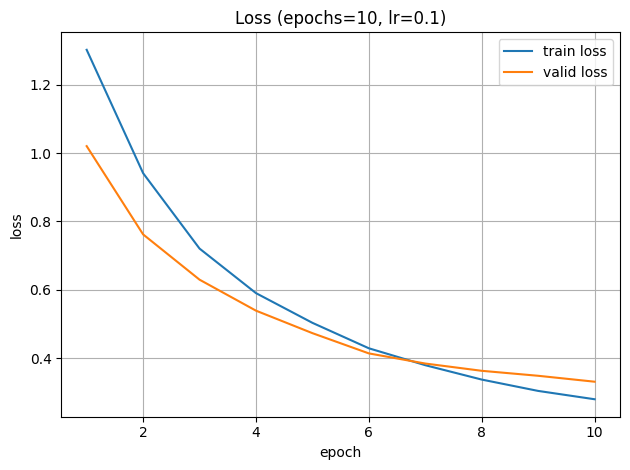

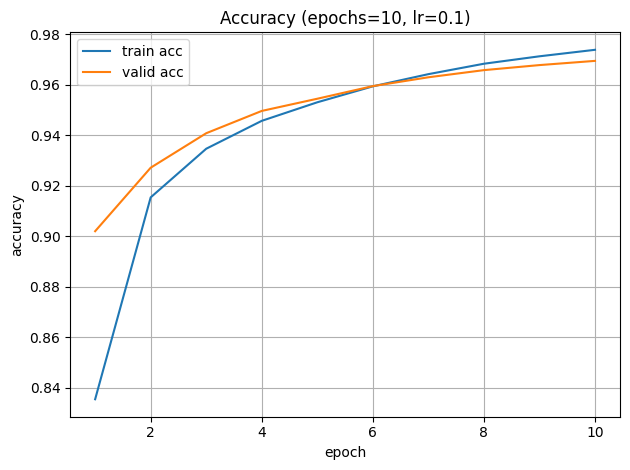

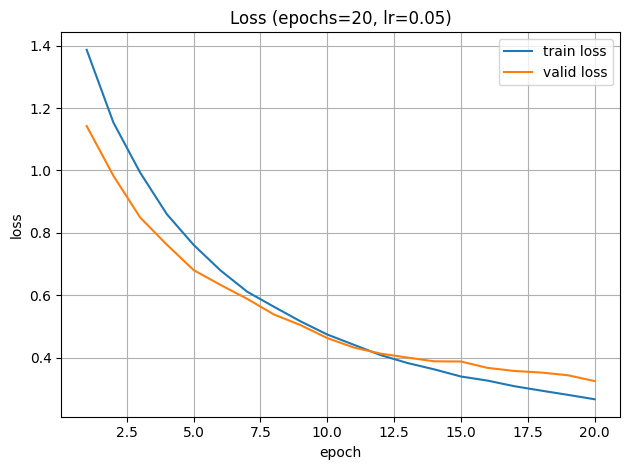

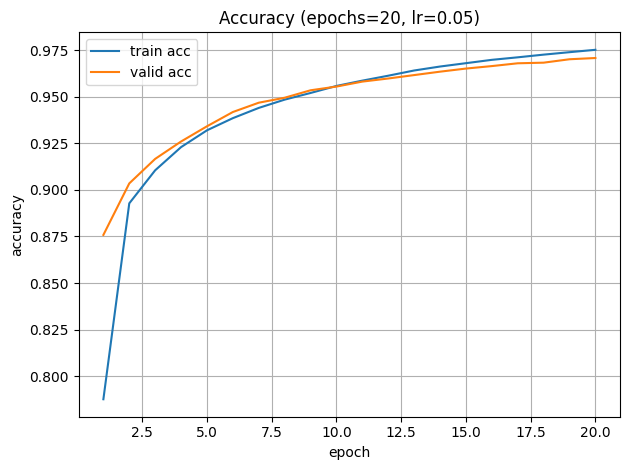

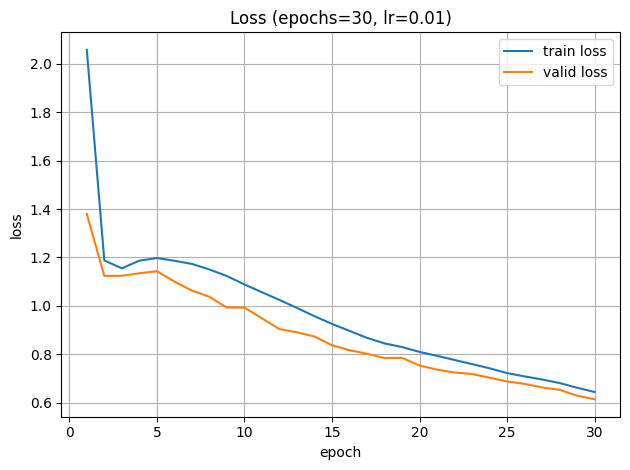

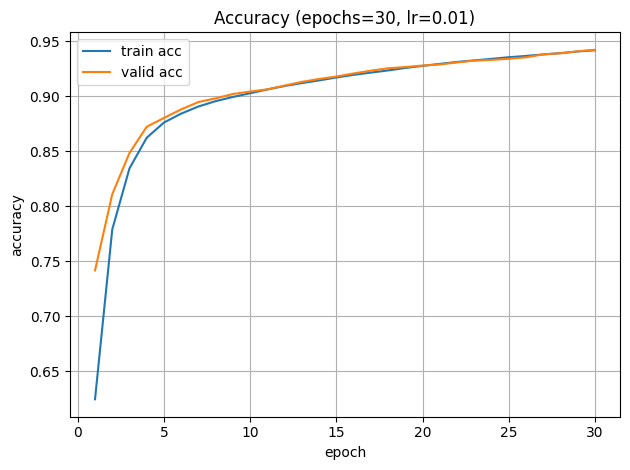

NameError: name 'csv' is not defined

In [13]:
# --------- 頂層 worker 函式（很重要：不要寫在函式內層或 lambda）---------
def run_experiment(cfg, data_root=".", batch_size=128, seed=42):
    """
    在獨立進程中執行一組 (epochs, lr) 訓練：
      1) 重新建立 dataloader（避免跨進程 pickle 問題）
      2) 建立新模型訓練
      3) 在 test set 上評估
      4) 回傳訓練歷史與測試分數
    """
    # 進程內設種子（數值版）
    np.random.seed(seed)

    # 重新建 dataloader（依你的資料位置調整 data_root / transform）
    trainldr, validldr, testldr = load_mnist_data(
        data_root, batch_size=batch_size, transform=transform
    )

    # 建立模型並訓練
    net = MLP()
    train_loss, train_acc, valid_loss, valid_acc = train(
        net, trainldr, validldr, epochs=cfg["epochs"], lr=cfg["lr"]
    )

    # 測試集評估
    test_loss, test_acc = evaluate(net, testldr)

    # 轉成基本型態，避免跨進程傳 cupy/tensor 等特殊型別
    return {
        "config": dict(cfg),
        "train_loss": list(map(float, train_loss)),
        "train_acc": list(map(float, train_acc)),
        "valid_loss": list(map(float, valid_loss)),
        "valid_acc": list(map(float, valid_acc)),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
    }

# --------- 主程式：開多核心跑多組超參數 ---------
def main_multicore():
    # 你要掃的 (epochs, lr) 清單（可自行增減）
    configs = [
        {"epochs": 10, "lr": 0.10},
        {"epochs": 20, "lr": 0.05},
        {"epochs": 30, "lr": 0.01},
    ]

    # 建議加大 batch_size，GPU 沒開也能讓曲線穩定許多
    batch_size = 128
    data_root = "."

    # 工作者數量：別把整機用滿，通常留 1 核給系統
    max_workers = max(1, (os.cpu_count()) - 2)

    print(f"Using CPU cores: {max_workers}")
    print("Submitting experiments...")
    ctx = mp.get_context("fork")
    results = []
    with ProcessPoolExecutor(max_workers=max_workers, mp_context=ctx) as ex:
        futures = [ex.submit(run_experiment, cfg, data_root, batch_size, 42)
                   for cfg in configs]
        for fut in as_completed(futures):
            res = fut.result()
            cfg = res["config"]
            print(f"Finished: epochs={cfg['epochs']}, lr={cfg['lr']}, "
                  f"test_loss={res['test_loss']:.4f}, test_acc={res['test_acc']:.4f}")
            results.append(res)
    # 繪圖（含 plt.show()）
    for res in results:
        cfg = res["config"]
        tl, vl = res["train_loss"], res["valid_loss"]
        ta, va = res["train_acc"], res["valid_acc"]

        plt.figure()
        plt.plot(range(1, len(tl)+1), tl, label="train loss")
        plt.plot(range(1, len(vl)+1), vl, label="valid loss")
        plt.xlabel("epoch"); plt.ylabel("loss")
        plt.title(f"Loss (epochs={cfg['epochs']}, lr={cfg['lr']})")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

        plt.figure()
        plt.plot(range(1, len(ta)+1), ta, label="train acc")
        plt.plot(range(1, len(va)+1), va, label="valid acc")
        plt.xlabel("epoch"); plt.ylabel("accuracy")
        plt.title(f"Accuracy (epochs={cfg['epochs']}, lr={cfg['lr']})")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    return results
    

if __name__ == "__main__":
    results = main_multicore()
    
    # ---- 總結（每個 run 一列）----
    summary_csv = "results_summary.csv"
    with open(summary_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "run_id", "epochs_cfg", "lr_cfg",
            "final_train_loss", "final_valid_loss",
            "final_train_acc", "final_valid_acc",
            "test_loss", "test_acc"
        ])
        for run_id, res in enumerate(results, start=1):
            cfg = res["config"]
            tl, vl = res["train_loss"], res["valid_loss"]
            ta, va = res["train_acc"], res["valid_acc"]
            writer.writerow([
                run_id, cfg["epochs"], cfg["lr"],
                tl[-1], vl[-1], ta[-1], va[-1],
                res["test_loss"], res["test_acc"]
            ])
    
    print(f"[CSV] summary written to: {summary_csv}")